В данной домашке предлагается воспроизвести результаты статьи [ArXiv:2006.08545](https://arxiv.org/abs/2006.08545), изучающей поведение NF на Out-Of-Distribution (OOD) данных (т.е. тех данных, которые поток никогда не видел и которые находятся за пределом распределения обучающей выборки)

In [13]:
!pip install wandb

## (0.3 балла) Обучить Glow на CelebA, добиться нормального качества генерируемых картинок

При невыполнении этого пункта все остальные пункты зануляются

In [18]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [6]:
import gdown
url = 'https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb'
output = 'celeba.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb
To: /content/celeba.zip
2.73GB [00:38, 71.5MB/s]


'celeba.zip'

In [7]:
%%bash

unzip -q ./celeba.zip
rm -r ./celeba/celeba/img_align_celeba
unzip -q ./celeba/celeba/img_align_celeba.zip
mv ./img_align_celeba ./celeba/celeba/img_align_celeba

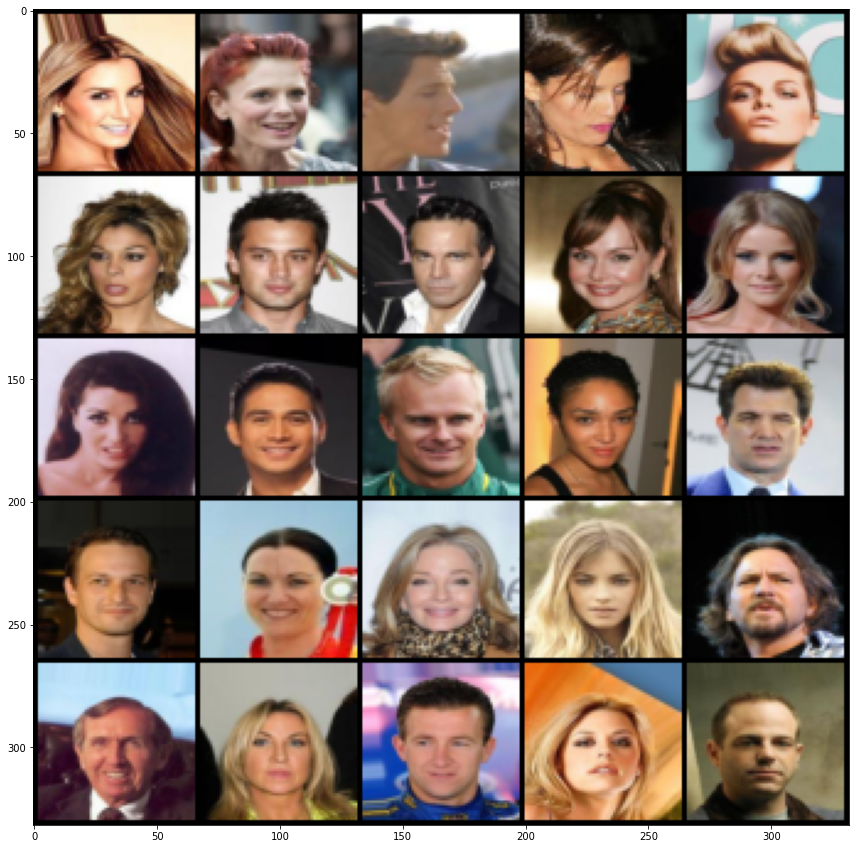

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip()
])
    
celeba_train = torchvision.datasets.CelebA('./celeba', target_type='attr', 
                                           transform=transforms, split="train", download=False)
celeba_val = torchvision.datasets.CelebA('./celeba', target_type='attr', 
                                         transform=transforms, split="valid", download=False)

plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_train[i][0] for i in range(25)], nrow=5).permute(1,2,0))
plt.show()

In [20]:
import sys
from fid import calculate_fid, make_inception_feature_extractor
from glow import Glow
from config import make_config
from utils import *

In [23]:
import sys
import wandb

import torch
from torch import nn, optim
from glow import Glow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = make_config()

model = Glow(config)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
classifier = make_inception_feature_extractor(device)

wandb.init(project='gen models hw3', name=f'Glow, repo, affine=True')
wandb.watch(model)
wandb.config.update(config)
torch.backends.cudnn.benchmark = True

celeba_train_dataloader = torch.utils.data.DataLoader(celeba_train, 
                                                      config.batch, 
                                                      shuffle=True, pin_memory=True, 
                                                      num_workers=4)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, 
                                                    config.batch, 
                                                    shuffle=False, drop_last=True,
                                                    pin_memory=True, num_workers=4)



Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
from math import log

def calc_loss(log_p, logdet, image_size, n_bins):
    n_pixel = image_size * image_size * 3
    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p
    log2 = log(2)
    return (
        (-loss / (log2 * n_pixel)).mean(),
        (log_p / (log2 * n_pixel)).mean(),
        (logdet / (log2 * n_pixel)).mean(),
    )

In [ ]:
n_bins = 2.0 ** config.n_bits
epochs = 8

CHECKPOINT = '/glow_{}.pt'

with torch.no_grad():
    image, label = next(iter(celeba_train_dataloader))
    model.init_with_data(image)
    image = image.to(device)
    log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)

for epoch in range(epochs):
    for step, (image, label) in enumerate(tqdm(celeba_train_dataloader, 
                                               leave=False, desc=f"trainloop: {epoch}")):
        real_image = image
        image = image.to(device)
        image = image * 255

        if config.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - config.n_bits))

        image = image / n_bins - 0.5
        log_p, logdet, z_outs = model(image + torch.rand_like(image) / n_bins)
        logdet = logdet.mean()
        loss, log_p, log_det = calc_loss(log_p, logdet, config.img_size, n_bins)

        model.zero_grad()
        loss.backward()
        warmup_lr = config.lr
        optimizer.param_groups[0]["lr"] = warmup_lr
        optimizer.step()

        wandb.log({'loss': loss.item(), 'log_p': log_p.item(), 'log_det': log_det.item()})

        if step % 100 == 0:
            with torch.no_grad():
                real_image = real_image.numpy()
                fake_image = model.reverse(z_outs, reconstruct=True).cpu().numpy()
                sampled_image = model.sample(config.n_sample).cpu().numpy()
                total_steps = step + epoch * len(celeba_train_dataloader)
                wandb.log({'step': step,
                            'real images': [
                            wandb.Image(real_image[i].transpose(1, 2, 0), 
                                        caption=f"real, step: {total_steps}") 
                            for i in range(config.batch)],
                            'fake images': [
                            wandb.Image(fake_image[i].transpose(1, 2, 0), 
                                        caption=f"fake, step: {total_steps}") 
                            for i in range(config.batch)],
                          'sampled images': [
                            wandb.Image(sampled_image[i].transpose(1, 2, 0), 
                                        caption=f"sampled, step: {total_steps}") 
                            for i in range(config.n_sample)]})
        
    torch.save({'model_state_dict': model.state_dict(), 
                'optimizer': optimizer.state_dict()
               }, CHECKPOINT.format(epoch))
    wandb.log({'fid': calculate_fid(celeba_val_dataloader, model, classifier, device)})

In [106]:
checkpoint = torch.load('glow_7.pt')
model.load_state_dict(checkpoint['model_state_dict'])
image, label = next(iter(celeba_train_dataloader))
model.init_with_data(image)

Этот ран: 
https://wandb.ai/arinaruck/gen%20models%20hw3/runs/1f3p514p/overview?workspace=user-arinaruck


Подробнее про подбор гиперпараметров и эксперименты в отчете за дз3: https://wandb.ai/arinaruck/gen%20models%20hw3/reports/Vmlldzo1NDYzNDQ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


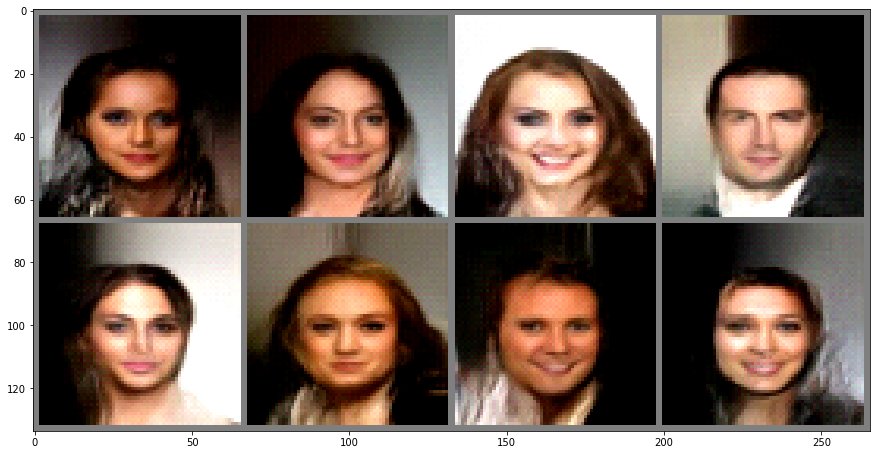

In [113]:
model.eval()
sampled = model.sample(8).cpu().numpy()
plt.figure(figsize=(15,15))
plt.imshow(make_grid([torch.as_tensor(sample) for sample in sampled], nrow=4).permute(1,2,0)* 2 + 0.5)
plt.show()

## (0.4 балла) Построить гистограмму лайклихудов для обученного в предыдущем пункте потока для данных CelebA (train), CelebA (test) и SVHN (OOD)
Замечание: из каждого датасета достаточно взять только некоторую долю объектов, достаточную для построения гистограммы 

In [35]:
celeba_test = torchvision.datasets.CelebA('./celeba', target_type='attr', 
                                         transform=transforms, split="test", download=False)
svhn = torchvision.datasets.SVHN('./svhn', split='test', transform=transforms, download=True)

Using downloaded and verified file: ./svhn/test_32x32.mat


In [36]:
import numpy as np
from torch.utils.data import Subset
sample_size = 100
subset_idx = np.random.choice(min(len(celeba_test), len(svhn)), 
                              size=sample_size, replace=False) 
celeba_train_loader = torch.utils.data.DataLoader(Subset(celeba_train, subset_idx), 1, 
                                          shuffle=False, pin_memory=True, 
                                          num_workers=2)
celeba_test_loader = torch.utils.data.DataLoader(Subset(celeba_test, subset_idx), 1, 
                                          shuffle=False, pin_memory=True, 
                                          num_workers=2)
svhn_loader = torch.utils.data.DataLoader(Subset(svhn, subset_idx), 1, 
                                          shuffle=False, pin_memory=True, 
                                          num_workers=2)

In [39]:
def get_log_likelihood(log_p, logdet, image_size, n_bins):
  return -calc_loss(log_p, logdet, image_size, n_bins)[0]

def filter_threshold(log_likelihood, threshold=-10000):
    print(np.sum(log_likelihood < threshold), "outliers")
    return log_likelihood[log_likelihood > threshold]

def get_ll(model, loader, sample_size):
    n_bins = 2.0 ** config.n_bits
    ll = np.zeros(sample_size)
    model.eval()
    for i, (image, label) in enumerate(tqdm(loader)):
        real_image = image
        image = image.to(device)
        image = image * 255

        if config.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - config.n_bits))

        image = image / n_bins - 0.5
        log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)
        logdet = logdet.mean()
        ll[i] = get_log_likelihood(log_p, logdet, config.img_size, n_bins)
    ll = filter_threshold(ll)
    return ll
      

In [114]:
import warnings
warnings.filterwarnings("ignore")

celeba_train_ll = get_ll(model, celeba_train_loader, sample_size)
celeba_test_ll = get_ll(model, celeba_test_loader, sample_size)
svhn_ll =  get_ll(model, svhn_loader, sample_size)


0 outliers



0 outliers



0 outliers


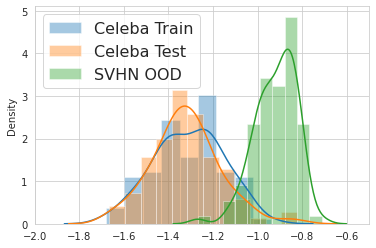

In [118]:
import seaborn as sns
sns.set_style('whitegrid')
sns.distplot(celeba_train_ll, label="Celeba Train")
sns.distplot(celeba_test_ll, label="Celeba Test")
sns.distplot(svhn_ll, label="SVHN OOD")
plt.xlim(-2, -0.5)
plt.legend(fontsize=16);

Как показано в статье, норм потоки выучивают правдоподобие на основе структуры изображений (скоррелированности пикселей), а не на основе контента изображений. Поэтому изображания из другого датасета не кажутся модели OOD, а так как они более гладкие (менее структурированные, фон однородный), чем celeba, то кажутся даже более правдоподобными.

## (0.3 балла) Сравнить картинки из OOD (SVHN) с наибольшим предсказанным лайклихудом с картинками обучающего датасета (CelebA) с наименьшим лайклихудом. Что можно сказать об этих картинках? Почему лайклихуд первых может быть выше?

In [119]:
k = 8
highest_ood = subset_idx[np.argsort(svhn_ll)[-k:]]
lowest_id = subset_idx[np.argsort(celeba_train_ll)[:k]]

In [120]:
sns.reset_orig()

## Высокое правдоподобие

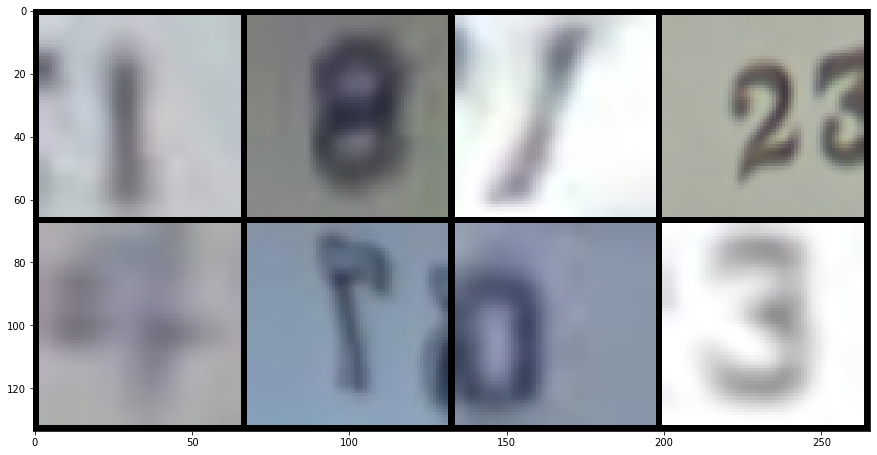

In [121]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid([svhn[i][0] for i in highest_ood], nrow=4).permute(1,2,0)) #* 0.5 + 0.5)
plt.show()

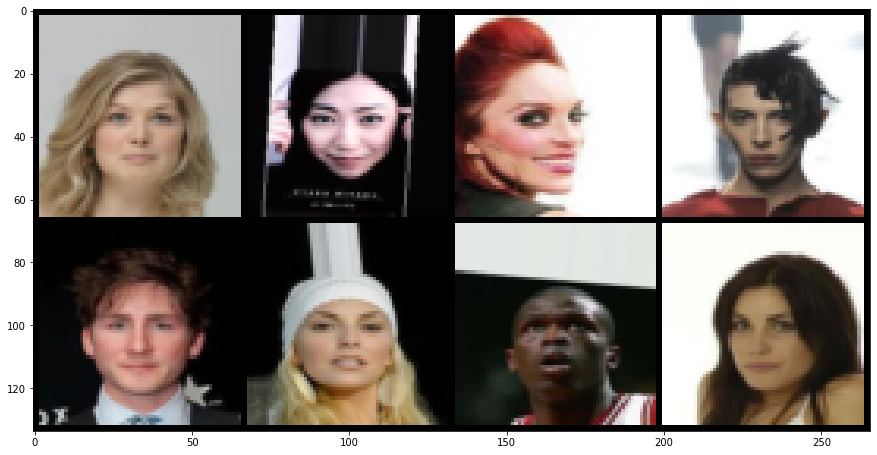

In [122]:
highest_id = subset_idx[np.argsort(celeba_train_ll)[-k:]]
plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_train[i][0] for i in highest_id], nrow=4).permute(1,2,0))
plt.show()

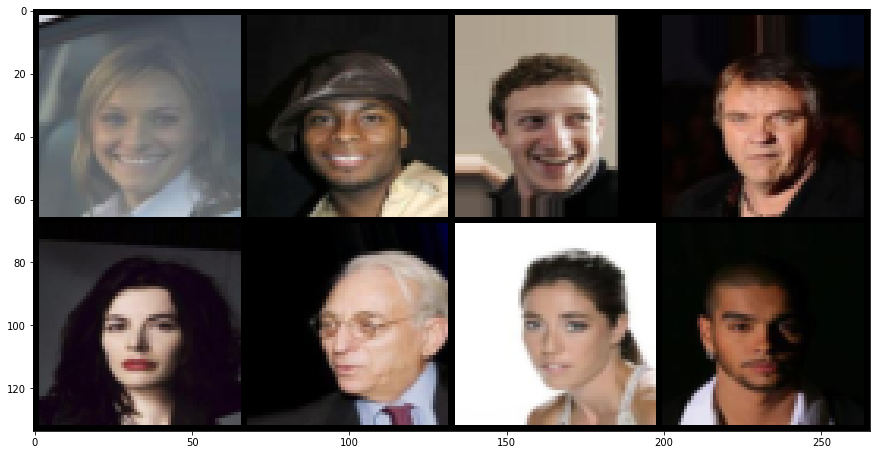

In [123]:
highest_id = subset_idx[np.argsort(celeba_test_ll)[-k:]]
plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_test[i][0] for i in highest_id], nrow=4).permute(1,2,0))
plt.show()

## Низкое правдоподобие

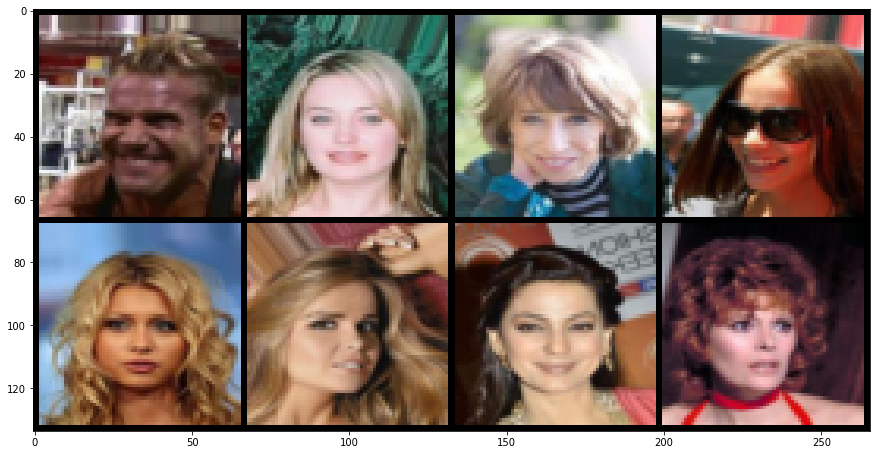

In [124]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_train[i][0] for i in lowest_id], nrow=4).permute(1,2,0))
plt.show()

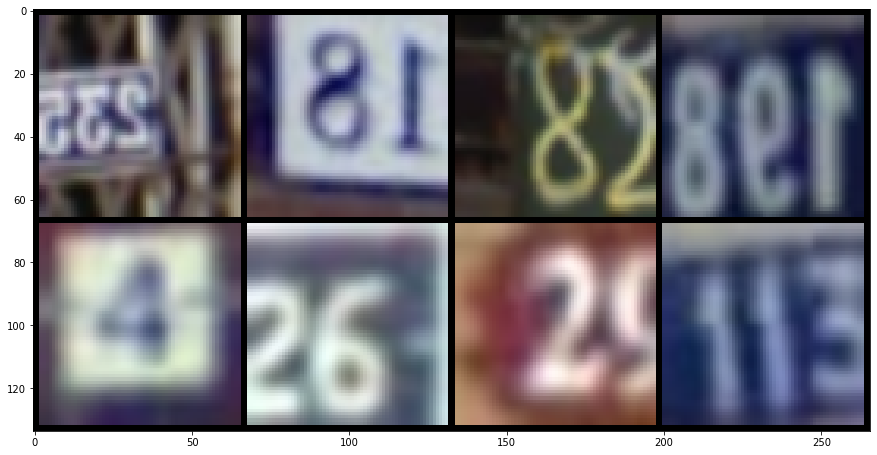

In [125]:
lowest_ood = subset_idx[np.argsort(svhn_ll)[:k]]
plt.figure(figsize=(15,15))
plt.imshow(make_grid([svhn[i][0] for i in lowest_ood], nrow=4).permute(1,2,0))
plt.show()

Можно заметить, что модель считает более правдоподобными однотонные светлые или темные изображения. Молее контрастные изображения, она относит как менее правдоподобным. Это связано как раз с тем, что модель опирается на корреляцию соседних пикселей для вычисления правдоподобия. 